Dataset for The Office Lines were obtained on Kaggle.

Episode Names for The Office were scraped from its wikipedia page.

IMDB scores were scraped from the IMDB website.

In [2]:
# Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import csv
import re
import math
import collections

### 1 Data Gathering

In [3]:
# Importing script
scripts = pd.read_csv("The_Office_lines.csv", header = 0)
print(scripts.head())
print(scripts.shape)

   id  season  episode  scene  \
0   1       1        1      1   
1   2       1        1      1   
2   3       1        1      1   
3   4       1        1      1   
4   5       1        1      1   

                                           line_text  speaker  deleted  
0  All right Jim. Your quarterlies look very good...  Michael    False  
1         Oh, I told you. I couldn't close it. So...      Jim    False  
2  So you've come to the master for guidance? Is ...  Michael    False  
3         Actually, you called me in here, but yeah.      Jim    False  
4    All right. Well, let me show you how it's done.  Michael    False  
(59909, 7)


In [80]:
# Web Scraping The Office Episodes
URL = "https://en.wikipedia.org/wiki/List_of_The_Office_(American_TV_series)_episodes"
page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')

table = soup.findAll('table',{"class":"wikiepisodetable"})[0:9]

tr = []
for season in table:
    tr.append(season.findAll(['tr'])[1:])
    
csvFile = open("office_eps.csv",'wt',newline='',encoding='utf-8')
writer = csv.writer(csvFile)  
try:   
    for item in tr:
        for cell in item:
            th = cell.find_all('th')
            th_data = [col.text.strip('\n') for col in th]
            td = cell.find_all('td')
            row = [i.text.replace('\n','') for i in td]
            writer.writerow(th_data+row)      
        
finally:   
    csvFile.close()

In [4]:
episodes = pd.read_csv("office_eps.csv", header = None)

In [4]:
episodes = episodes.drop([6], axis=1)
episodes.columns = ["Overall No", "Season Ep No", "Title", "Director", "Writer", "Air Date", "Viewers"]

In [5]:
episodes.head()

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers
0,1,1,"""Pilot""",Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,"March 24, 2005 (2005-03-24)",11.20[16]
1,2,2,"""Diversity Day""",Ken Kwapis,B. J. Novak,"March 29, 2005 (2005-03-29)",6.00[17]
2,3,3,"""Health Care""",Ken Whittingham,Paul Lieberstein,"April 5, 2005 (2005-04-05)",5.80[18]
3,4,4,"""The Alliance""",Bryan Gordon,Michael Schur,"April 12, 2005 (2005-04-12)",5.40[19]
4,5,5,"""Basketball""",Greg Daniels,Greg Daniels,"April 19, 2005 (2005-04-19)",5.00[20]


In [5]:
# Extracting IMDB Episode Ratings

data_set = []
for i in range(1, 10):
    URL = "https://www.imdb.com/title/tt0386676/episodes?season=" + str(i)
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    eps = soup.findAll("div", {"class": "list_item"})
    for episode in eps:
        title = episode.findAll("a", {"itemprop": "name"})
        rating = episode.findAll("span", {"class": "ipl-rating-star__rating"})
        voters = episode.findAll("span", {"class": "ipl-rating-star__total-votes"})
        row_data = [title[0].text,rating[0].text,voters[0].text[1:-1].replace(',','')]
        row_data = [r.replace('\n','').strip() for r in row_data]
        data_set.append(row_data)

In [6]:
imdb = pd.DataFrame(data_set,columns=['Title','Rating','Voters'])
imdb.head()

,Title,Rating,Voters
0,Pilot,7.5,6184
1,Diversity Day,8.3,6062
2,Health Care,7.8,5078
3,The Alliance,8.0,4941
4,Basketball,8.4,5465


In [8]:
imdb.to_csv("imdb.csv", index = False)

In [5]:
imdb = pd.read_csv("imdb.csv", header = 0)

### 2 Data Cleaning

#### Episodes DF

In [9]:
# Helper Function
def adjust_ep(df_line):
    if len(df_line['Overall No']) > 3:
        return df_line['Season Ep No'][:int(len(df_line['Season Ep No'])/2)]
    else:
        return df_line['Season Ep No']

In [10]:
# Address issue of double episodes
episodes = episodes.astype({'Overall No': 'str', 'Season Ep No': 'str'})
episodes['Season Ep No'] = episodes.apply(adjust_ep, axis=1)
episodes['Overall No'] = episodes['Overall No'].apply(lambda x: x[:int(len(x)/2)] if len(x) > 3 else x)

In [11]:
# Clean vieweres column
episodes['Viewers'] = episodes['Viewers'].apply(lambda x: re.search(r"(\d+.\d+)(?=\[)", x).group(0))

In [12]:
# Clean Air Date Column
episodes['Air Date'] = episodes['Air Date'].apply(lambda x: re.search(r"(?!\()(\d+-\d+-\d+)", x).group(0))

In [13]:
# Clean Title Column
episodes['Title'] = episodes['Title'].apply(lambda x: x.replace('"', '').replace('‡', '').replace('*', '').replace('†', ''))

In [14]:
# Add Season Column
Season = np.array([1])

count = 1
for i in range(1, 186):
    if episodes.iloc[i,1] != '1':
        Season = np.append(Season, count)
    else:
        count += 1
        Season = np.append(Season, count)

episodes['Season'] = Season

#### Scripts DF

In [15]:
# I filtered for the top 8 chracters by number of lines
most_lines = collections.Counter(scripts.speaker).most_common()[0:8]
most_lines_filter = []
for item in most_lines:
    most_lines_filter.append(item[0])
scripts_filtered = scripts[scripts.speaker.isin(most_lines_filter)]
scripts_filtered.speaker.unique()

In [23]:
# I filtered for lines which were actually spoken in the series and not deleted
scripts_filtered = scripts_filtered.loc[scripts_filtered.deleted == False,]

In [24]:
scripts_filtered.to_csv("script.csv", index = False)

### Data Merging

In [18]:
# Merge Episodes dataframe with imdb dataframe

new_episodes = episodes.merge(imdb, on = 'Title', how = 'left')
new_episodes = new_episodes.astype({'Rating': 'float', 'Voters': 'float'})

In [19]:
# Detecting episodes which failed to merge to due slight differences in titles
new_episodes.loc[np.isnan(new_episodes.Rating),:]

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers,Season,Rating,Voters
14,15,9,Email Surveillance,Paul Feig,Jennifer Celotta,2005-11-22,8.10,2,NaN,NaN
94,104,4,Niagara,Paul Feig,Greg Daniels & Mindy Kaling,2009-10-08,9.42,6,NaN,NaN
105,116,16,The Manager and the Salesman,Marc Webb,Mindy Kaling,2010-02-11,7.40,6,NaN,NaN
106,117,17,The Delivery,Seth GordonHarold Ramis,Daniel ChunCharlie Grandy,2010-03-04,9.00,6,NaN,NaN


In [20]:
# Correcting NaNs
new_episodes.iloc[14, 8:10] = 8.4, 4227
new_episodes.iloc[94, 8:10] = (9.4 + 9.5)/2, (5680 + 4433)/2
new_episodes.iloc[105, 8:10] = 8.1, 2872
new_episodes.iloc[106, 8:10] = (8.4 + 8.5)/2, (3052 + 3056)/2

In [21]:
new_episodes.loc[np.isnan(new_episodes.Rating),:]

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers,Season,Rating,Voters


In [22]:
new_episodes = new_episodes.astype({'Overall No': 'int', 'Season Ep No': 'int', 'Viewers': 'float'})

In [25]:
new_episodes.to_csv("episodes.csv", index = False)

In [7]:
new_episodes = pd.read_csv("episodes.csv", header = 0)

In [8]:
new_episodes.head(5)

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers,Season,Rating,Voters
0,1,1,Pilot,Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,2005-03-24,11.2,1,7.5,6184.0
1,2,2,Diversity Day,Ken Kwapis,B. J. Novak,2005-03-29,6.0,1,8.3,6062.0
2,3,3,Health Care,Ken Whittingham,Paul Lieberstein,2005-04-05,5.8,1,7.8,5078.0
3,4,4,The Alliance,Bryan Gordon,Michael Schur,2005-04-12,5.4,1,8.0,4941.0
4,5,5,Basketball,Greg Daniels,Greg Daniels,2005-04-19,5.0,1,8.4,5465.0


### Exploratory Data Analysis

<AxesSubplot:xlabel='Viewers'>

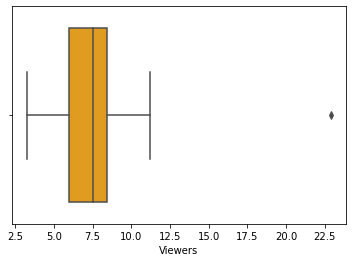

In [26]:
sns.boxplot(x = new_episodes.Viewers, color = "orange")

We observe and anomaly in one of the episodes with more than 22.5 million viewers

In [27]:
new_episodes.loc[new_episodes.Viewers > 22,:]

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers,Season,Rating,Voters
77,86,14,Stress Relief,Jeffrey Blitz,Paul Lieberstein,2009-02-01,22.91,5,9.7,10506.0


Stress Relief is the episode with the anomaly. Research online points to the fact that the episode was broadcasted after  Super Bowl XLIII, which was the most watched Super Bowl in history at that time.

<AxesSubplot:xlabel='Rating'>

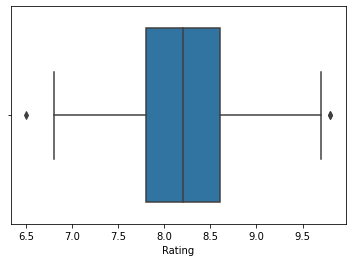

In [28]:
sns.boxplot(x = new_episodes.Rating)

In general, the Office episodes are highly rater by viewers, having a median of around 8.3 and with more than 25% of the episodes being rated more than 8.5 out of 10.

<AxesSubplot:xlabel='Overall No', ylabel='Viewers'>

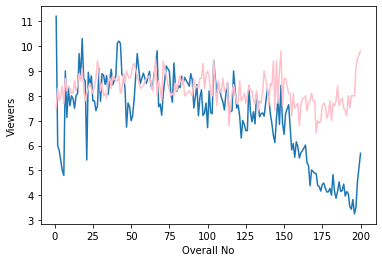

In [30]:
sns.lineplot(x = "Overall No", y = "Viewers",data = new_episodes.loc[new_episodes.Viewers < 22,:])
sns.lineplot(x = "Overall No", y = "Rating",data = new_episodes.loc[new_episodes.Viewers < 22,:], color = "pink")

<AxesSubplot:xlabel='Season', ylabel='Viewers'>

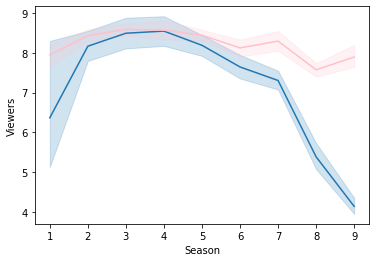

In [29]:
sns.lineplot(x = "Season", y = "Viewers",data = new_episodes.loc[new_episodes.Viewers < 22,:])
sns.lineplot(x = "Season", y = "Rating",data = new_episodes.loc[new_episodes.Viewers < 22,:], color = "pink")

For my initial analysis, I did not take into account the episode with the viewership anomaly. My plot suggests that ratings for the show generally remained constant. However, for viewership, I realised that there is a sudden decrease in viewers for the last 50 episodes. Furthermore, when compared across seasons, we see that there was increased viewership since the pilot season, and then there was the slight drop from season 4 to 7, before the sudden drop in the last 3 seasons.

<AxesSubplot:xlabel='speaker', ylabel='count'>

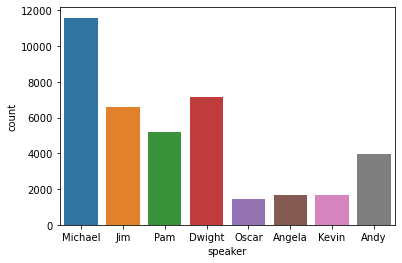

In [121]:
# Number of lines of top 
sns.countplot(x = "speaker", data = scripts_filtered)

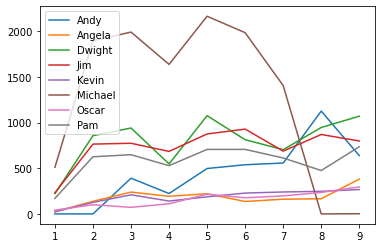

In [92]:
line_number = scripts_filtered.groupby(['season', 'speaker']).agg(['count']).line_text.unstack()
line_number = line_number.fillna(0)
names = ["Andy", "Angela", "Dwight", "Jim", "Kevin", "Michael", "Oscar", "Pam"]

plt.plot(line_number)
plt.legend(names)

We see that Michael no longer appears in season 8 and 9, and the fall in viewership could be attributed to that.

### Analysis of Michael Scott's Influence on the Show

#### Ratings Analysis

In [11]:
new_episodes.loc[new_episodes.Title == "Goodbye, Michael",:]

,Overall No,Season Ep No,Title,Director,Writer,Air Date,Viewers,Season,Rating,Voters
135,148,22,"Goodbye, Michael",Paul Feig,Greg Daniels,2011-04-28,8.42,7,9.8,10717.0


In [16]:
new_episodes["michael"] = new_episodes["Overall No"].apply(lambda x: False if x > 148 else True)

<AxesSubplot:xlabel='michael', ylabel='Rating'>

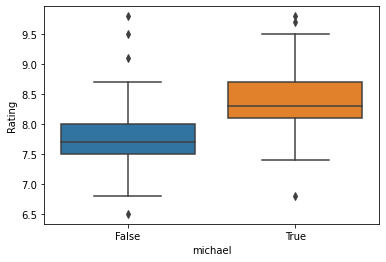

In [18]:
sns.boxplot(x = new_episodes.michael, y = new_episodes.Rating)

<AxesSubplot:xlabel='Rating', ylabel='Count'>

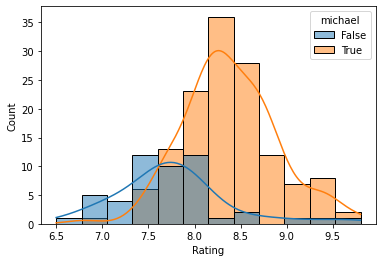

In [37]:
sns.histplot(x = "Rating", hue = "michael", data = new_episodes, kde = True)

From the boxplots, we observe that there maybe be higher ratings in episodes with Michael Scott.

In [23]:
# Statistical Analysis
from scipy import stats

In [38]:
michael_ratings = np.array(new_episodes.loc[new_episodes.michael == True, "Rating"])
no_michael_ratings = np.array(new_episodes.loc[new_episodes.michael == False, "Rating"])

stats.ttest_ind(michael_ratings, no_michael_ratings, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=6.324573818965778, pvalue=8.574180812395787e-09)

The null hypothesis is that there are no significant differences in ratings of episodes with Michael and without Michael.

The alternative hypothesis is that ratings of episodes with Michael is greater than those without Michael.

Our 2 sample t-test result has a p-value of 8.574180812395787e-09, which is less than selected siginificant level of 0.05. Hence, the null hypothesis is rejected. There is enough evidence to show that ratings of episodes with Michael is greater than those without Michael.

#### Viewership Analysis

We will remove the anomaly, which is the episode with 22.5 million viewers for this analysis>

<AxesSubplot:xlabel='michael', ylabel='Viewers'>

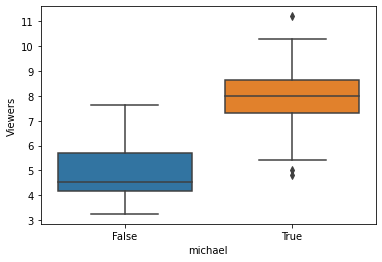

In [41]:
sns.boxplot(x = new_episodes.michael, y = new_episodes.loc[new_episodes.Viewers < 22,:].Viewers)

<AxesSubplot:xlabel='Viewers', ylabel='Count'>

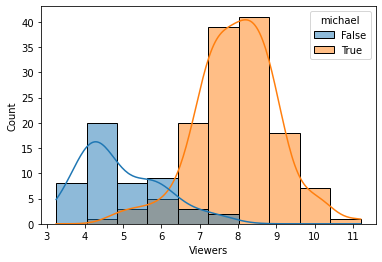

In [42]:
sns.histplot(x = "Viewers", hue = "michael", data = new_episodes.loc[new_episodes.Viewers < 22,:], kde = True)

In [43]:
michael_viewers = np.array(new_episodes.loc[(new_episodes.michael == True) & (new_episodes.Viewers < 22), "Viewers"])
no_michael_viewers = np.array(new_episodes.loc[(new_episodes.michael == False) & (new_episodes.Viewers < 22), "Viewers"])

stats.ttest_ind(michael_viewers, no_michael_viewers, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=17.77127718570523, pvalue=3.890620846357668e-31)

The null hypothesis is that there are no significant differences in number of viewers of episodes with Michael and without Michael.

The alternative hypothesis is that number of viewers of episodes with Michael is greater than those without Michael.

Our 2 sample t-test result has a p-value of 3.890620846357668e-31, which is less than selected siginificant level of 0.05. Hence, the null hypothesis is rejected. There is enough evidence to show that number of viewers of episodes with Michael is greater than those without Michael.

#### Conclusion

Hence, based on my data visualizations and statistical analysis, the drop in rating and viewers in the last two seasons can be attributed to Steve Carrell's character Michael Scott leaving the show.

### Flesch Reading Score Analysis

In Progress